# Assignment 3: Stochastic models
## [Models in Population Biology](https://modelspopbiol.yoavram.com/)
## Yoav Ram

# General instructions

1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that the last cell in the notebook says __end of assignment__; if you are missing anything please download the origianl file from the course website.
1. This exercise doesn't put much emphasis on efficieny or runtime. But, your code should still run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, wherever possible.
1. Questions regarding the exercises should be posted to the course forum. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the course website.

In [1]:
###
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from functools import partial
from scipy.integrate import solve_ivp

sns.set_palette('Set1')
red, blue, green = sns.color_palette('Set1', 3)

# Ex 1: Model adaptive peak shifts

We model a population of bacteria and focus on two specific genes responsible for metabolism of lactose.
The first gene has two variants, or alleles: bacteria with the $A$ allele will transport lactose inside their cell, whereas bacteria with the $a$ allele will not, and therefore will not metabolise lactose.
The second gene also has two alleles: bacteria with the $B$ allele will be able to digest lactose and convert it to energy, whereas bacteria with the $b$ allele will not.
This is a simplifcation, of course; here is a paper on this system:
> Perfeito, Lília, Stéphane Ghozzi, Johannes Berg, Karin Schnetz, and Michael Lässig. 2011. “Nonlinear Fitness Landscape of a Molecular Pathway.” PLoS Genetics 7 (7): e1002160. https://doi.org/10.1371/journal.pgen.1002160.

Therefore, the most fit bacteria are of type $AB$, which can both transport lactose into the cell and digest it.
However, types $Ab$ and $aB$ (transport without digestion, digestion without transport, respectively), are less fit then type $ab$.
This is because $ab$ cells will neither transport or digest, but will also avoid the costs of producing the proteins required for transportation and digestion.
We therefore denote the fitness of $ab$ as $1$, the fitness of $Ab$ and $aB$ as $1-s$ (for $s>0$) and the fitness of $AB$ as $1+sH$ (for $H>0$).

Mutations can change the alleles of bacteria: with probability $u$ the allele at either gene changes, so that $A$ becomes $a$ and vice versa or $B$ becomes $b$ and vice versa. $u$ is called the _mutation rate_.

We focus on a population with $N$ cells of type $ab$, and ask: how can the double-mutant $AB$ appear and fix in the population, if both $Ab$ and $aB$ are less fit than $ab$?

This is problem is often called _adaptive peak shift_, (attributed to Sewall Wright, 1931): the types $ab$ and $AB$ are two fitness "peaks", and the types $Ab$ and $aB$ are two fitness "valleys"; in order to move from the local fitness peak $ab$ to the global fitness peak $AB$, the population has to "go through" the valleys $Ab$ and $aB$. 
You can see some demonstrations on [Bjørn Østman's website](http://bjornostman.com/landscapes.html).

More formally, a single-mutant individual has to appear by mutation, and a second mutation must occur before this single-mutant is purged from the population due to its fitness disadvantage ($1-s$). Then, the double-mutant must survive random events (i.e. genetic drift) and fix in the population, due to its fitness advantage ($1+sH$). Survival of random events is not certain, as we saw in Lecture 3.

Therefore the process is composed of two stages: 
1. waiting for the double-mutant to appear, 
2. waiting for the double-mutant to go to extinction (back to stage 1) or fixation (finish adaptation process).

Here, we are interested in characterizing the probability  of fixation of a newly appeared double-mutant and the distribution of waiting times.

## Mathematical model

The model can be summarized with the following table:
$$
\matrix{
Type & ab & Ab & aB & AB \\
Frequency & x_0 & x_1 & x_2 & x_3 \\
Fitness & 1 & 1-s & 1-s & 1+sH \\
}
$$

We follow the Wright-Fisher model (Lecture 5).
Given the frequencies of the four types in the previous generation $x_0, x_1, x_2, x_3$ the frequencies after mutation are:

$$
x_0^m = (1-u)^2 x_0 + (1-u) u x_1 + (1-u) u x_2 + u^2 x_3 $$$$
x_1^m = (1-u)^2 x_1 + (1-u) u x_0 + (1-u) u x_3 + u^2 x_2 $$$$
x_2^m = (1-u)^2 x_2 + (1-u) u x_0 + (1-u) u x_3 + u^2 x_1 $$$$
x_3^m = (1-u)^2 x_3 + (1-u) u x_1 + (1-u) u x_2 + u^2 x_0 
$$

because mutations can occur either in one gene ($u(1-u)$) or in the other gene ($u(1-u)$) or in both ($u^2$) or in neither ($(1-u)^2$).

The frequencies after selection (i.e. differential growth and reproduction) are then (see Lecture 4):

$$
x_i^s = \frac{w_i x_i^m}{\sum_{j=0}^{3}{w_j x_j^m}}
$$

where $w_0=1, w_1=w_2=1-s, w_3=1+sH$.

The frequencies in the next generation $x'_0, x'_1, x'_2, x'_3$, after genetic drift (i.e. random sampling, see Lecture 5), are:

$$
(n_0, n_1, n_2, n_3) \sim \text{Multinomial}\big(N, (x_0^s, x_1^s, x_2^s, x_3^s)\big) \\
x'_i = \frac{n_i}{N}
$$

where $n_i$ is the number of cells of type $i$ after random drift, and $x'_i$ is the frequency of cells after random drift.

This can also be written in matrix form, as matrix implementations would be much faster; in the following, **bold** symbols represent vectors (lowercase) or matrices (uppercase).
Given the frequencies of the four types in the previous generation  ${\bf x}=(x_0, x_1, x_2, x_3)$, the frequencies after mutation are:

$$
{\bf x^m} = {\bf M \cdot x}
$$

where $\bf M$ is the mutation matrix:

$$
\bf M = \pmatrix{
    (1-u)^2 & u(1-u) & u(1-u) & u^2 \\
    u(1-u) & (1-u)^2 & u^2 & u(1-u) \\
    u(1-u) & u^2 & (1-u)^2 & u(1-u) \\
    u^2 & u(1-u) & u(1-u) & (1-u)^2
}
$$

The frequencies after selection are:

$$
{\bf x^s} = {\bf S \cdot x^m}
$$

where $\bf S$ is the selection matrix:

$$
\bf S = \pmatrix{
    1 & 0 & 0 & 0 \\
    0 & 1-s & 0 & 0 \\
    0 & 0 & 1-s & 0 \\
    0 & 0 & 0 & 1+sH    
}
$$

And finally the frequencies at the next generation are:

$$
{\bf x'} \sim \frac{\text{Multinomial}\big(N, {\bf x^s}\big)}{N}
$$

## Implementation

First, **implement a function `evolution(N, u, s, H)`** that takes the model parameters (population size $N$, mutation rate $u$, selection coefficients $s$ and $H$), and runs the evolution process until the dobule-mutant appears ($x_3>0$) and then either goes to extinction ($x_3=0$) or to fixation ($x_3 \approx 1$); fixation can be defined as taking over a high percentage of the population, rather than 100%.

The function will return the results:
1. a boolean specifying if the dobule-mutant fixed, 
1. the number of generations until the double-mutant appeared,
1. the number of generations until the double-mutant either fixed or went extinct (counting since the appearance),
1. and the frequencies of the four types at each generation as a 2D array (shape is `(time, types)`).

The initial population is composed entierly from $ab$ individuals ($x_0=1, x_1=x_2=x_3=0$).

Later, you will run this function many times, so think about efficiency: vectorization, numba, broadcasting, early stopping. Since keeping track of the frequencies of the different types at all times is computationally and memory intensive, you can add a flag to turn this behaviour on or off (this flag can be called `history`).

In [2]:
def evolution(N, u, s, H, history=False): ###
    hist = None
    n = np.zeros(4, dtype=int)
    n[0] = N
    if history: hist = [n]
    
    M = np.array([
        [(1-u)**2, u*(1-u), u*(1-u), u**2],
        [u*(1-u), (1-u)**2, u**2, u*(1-u)],
        [u*(1-u), u**2, (1-u)**2, u*(1-u)],
        [u**2, u*(1-u), u*(1-u), (1-u)**2]
    ])
    assert np.allclose(M.sum(axis=0), 1)
    S = np.zeros((4,4), dtype=float)
    S[0,0], S[1,1], S[2,2], S[3,3] = 1, 1-s, 1-s, 1+s*H
    E = S @ M
    
    # wait for appearance
    t1 = 0
    while n[3] == 0:
        t1 += 1
        x = E @ n
        x /= x.sum()
        n = np.random.multinomial(N, x)
        if history: hist.append(n)

    # wait for extinction or fixation
    t2 = 0
    while 0 < n[3] < N*0.9999:
        t2 += 1
        x = E @ n
        x /= x.sum()
        n = np.random.multinomial(N, x)
        if history: hist.append(n)

    if history: 
        return n[3] > 0, t1, t2, np.array(hist)/N
    return n[3] > 0, t1, t2

**Plot a figure** with two axes deonstrating example dynamics -- the genotype frequencies over time.

The left panel should show dynamics of appearance and fixation of the double mutant $AB$.
The right panel should show dynamics of appearance and extinction of the double mutant.

You can choose whatever parameters you want that produce interesting dynamics.
If you are unsure, you can use: $N=10^7, u=10^{-6}, s=0.05, H=2.0$.

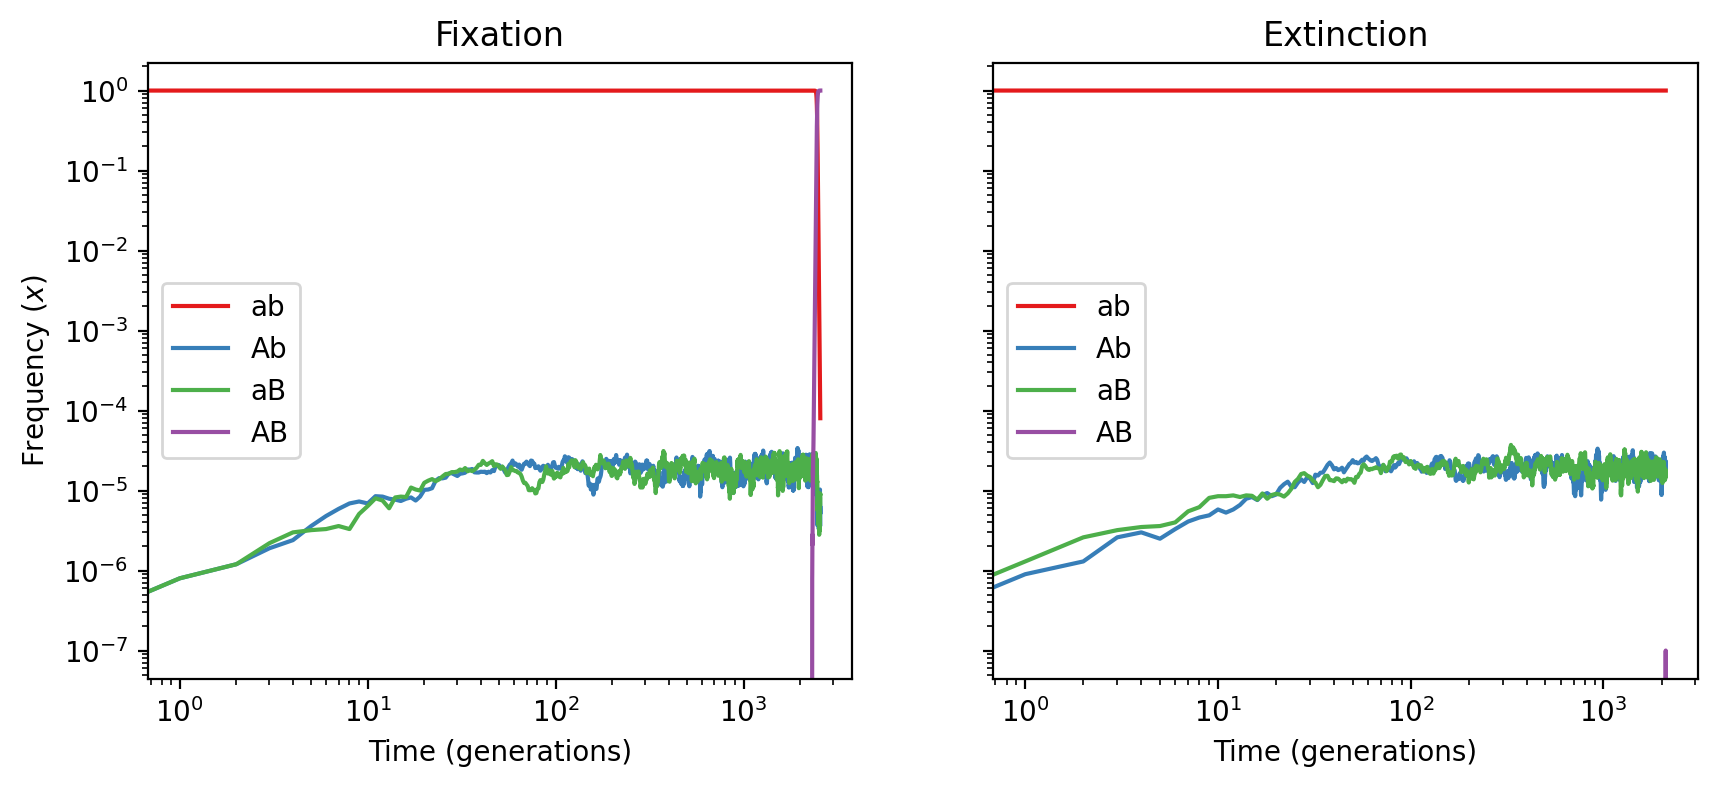

In [3]:
N, u, s, H = int(1e7), 1e-6, 0.05, 2.0

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=False)

fix = False
while not fix:
    fix, t1, t2, x = evolution(N, u, s, H, history=True)

ax = axes[0]
ax.plot(x)
ax.legend(['ab', 'Ab', 'aB', 'AB'])
ax.set_xlabel('Time (generations)')
ax.set_ylabel('Frequency ($x$)')    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Fixation')

ax = axes[1]
fix = True
while fix:
    fix, t1, t2, x = evolution(N, u, s, H, history=True)
ax.plot(x)
ax.legend(['ab', 'Ab', 'aB', 'AB'])
ax.set_xlabel('Time (generations)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Extinction');

## Simulation results

Now, **run multiple simulations and plot a figure** that illustrates:
1. the fixation probability of a newly appeared double-mutant, 
1. the distribution of the time for appearance of the double-mutant,
1. the distribution of the time for fixation of a double-mutant (given it appeared and fixed), 
1. the distribution of the time for extinction of a double-mutant (given it appeared and did not fix).

Run as many simulations as you think are needed to demonstrate the above.
Consider using multithreading or multiprocessing (see example in end of lecture 5).
Start with a few simulations, make sure everything works fine, then go big.

In [4]:
import concurrent.futures

def evolution_reps(N, u, s, H, reps=1):
    with concurrent.futures.ThreadPoolExecutor() as exec:
        futures = [exec.submit(evolution, N, u, s, H) for _ in range(reps)]
    fixations = np.empty(reps, dtype=bool)
    apper_times = np.empty(reps, dtype=int)
    fix_times = np.empty(reps, dtype=int)
    for i, f in enumerate(concurrent.futures.as_completed(futures)):
        if f.exception():
            print("Job failed:", f.exception())
            continue
        fix, t1, t2 = f.result()
        fixations[i] = fix
        apper_times[i] = t1
        fix_times[i] = t2
    return fixations, apper_times, fix_times
    
evolution_reps(N, u, s, H, reps=1);

In [5]:
fixations, apper_times, fix_times = evolution_reps(N, u, s, H, reps=5000)

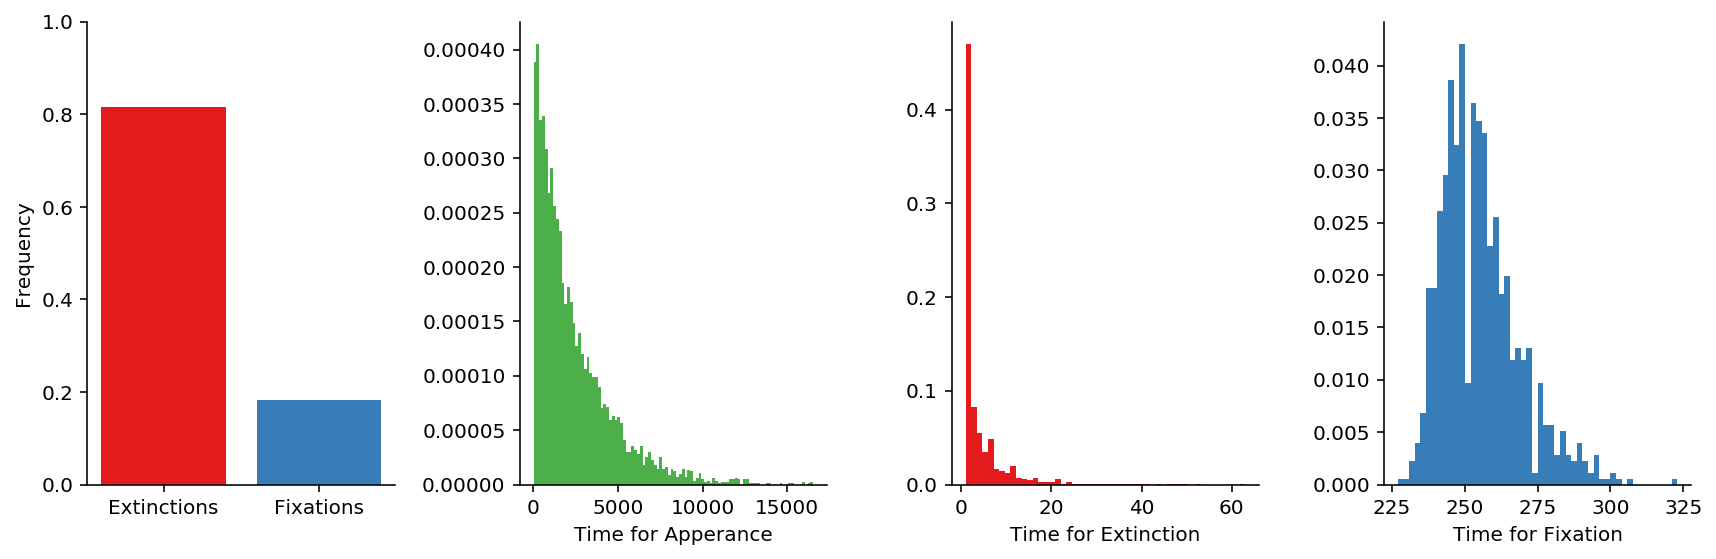

In [34]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
red, blue, green = sns.color_palette('Set1', 3)
                         
ax = axes[0]
ax.bar([0, 1], [1-fixations.mean(), fixations.mean()], color=[red, blue])
ax.set(xticks=[0, 1], xticklabels=['Extinctions', 'Fixations'], ylabel='Frequency', ylim=(0, 1))

ax = axes[1]
ax.hist(apper_times, bins=100, color=green, density=True)
ax.set(xlabel='Time for Apperance')

ax = axes[2]
ax.hist(fix_times[~fixations], bins=50, color=red, density=True)
ax.set(xlabel='Time for Extinction')

ax = axes[3]
ax.hist(fix_times[fixations], bins=50, color=blue, density=True)
ax.set(xlabel='Time for Fixation')

fig.tight_layout()
sns.despine()

# Ex 2: Predator-prey Gillespie implementation

## Deterministic model
Recall the deterministic predator-prey model from class.

In [7]:
# model parameters
b = 1
h = 0.005
ϵ = 0.8
d = 0.6

steps = 100000 # number integration steps
x0, y0 = 50, 100 # initial population sizes
dt = 0.001 # time step for integration

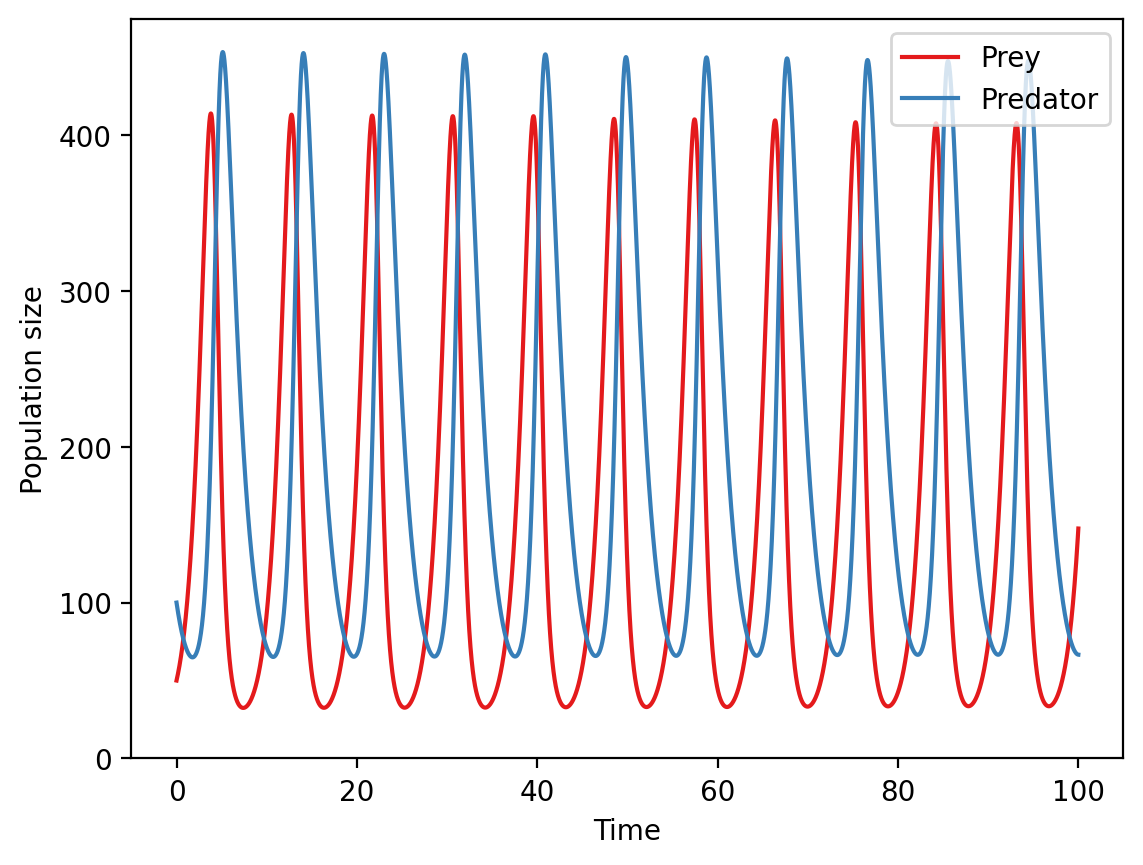

In [8]:
### deterministic model from class
def dxydt(t, xy, b, h, ϵ, d):
    x, y = xy
    dx = b * x - h * x * y
    dy = ϵ * h * x * y - d * y
    return np.array([dx, dy])
def jac(t, xy, b, h, ϵ, d):
    x, y = xy
    return np.array([
        [b - h * y, -h * x],
        [ϵ * h * y, ϵ * h * x - d]
    ])
def ode_integration(b, h, ϵ, d, t0=0, x0=x0, y0=y0, t_steps=steps, tmax=steps*dt):
    t = np.linspace(t0, tmax, steps)
    xy0 = (x0, y0)
    dxydt_ = partial(dxydt, b=b, h=h, ϵ=ϵ, d=d)
    jac_ = partial(jac, b=b, h=h, ϵ=ϵ, d=d)
    sol = solve_ivp(dxydt_, (t.min(), t.max()), xy0, t_eval=t, method='BDF', jac=jac_)
    return t, sol.y[0], sol.y[1]
    
T, X, Y = ode_integration(b, h, ϵ, d)

fig, ax = plt.subplots()
ax.plot(T, X)
ax.plot(T, Y)
ax.set(xlabel='Time', ylabel='Population size', ylim=(0, None))
ax.legend(['Prey', 'Predator'], loc=1);

## Stochastic model

**Implement a Gillespie simulation for the predator-prey dynamics.**

**Run a single simulation and plot it together with the deterministic dynamics.**

Note that once the predators are extinct there is no reason to continue running the simulation as the prey will just grow exponentially according to $dx/dt = bx$.

In [9]:
def get_rates(x, y, b, h, ϵ, d):
    return np.array([
        b * x,  
        (1 - ϵ) * h * x * y,
        ϵ * h * x * y,
        d * y  
    ])

In [10]:
def draw_time(rates):
    assert rates.sum() > 0, rates
    total_rate = rates.sum()
    return np.random.exponential(1/total_rate)

In [11]:
def draw_reaction(rates):
    assert rates.sum() > 0, rates
    rates /= rates.sum()
    return np.random.multinomial(1, rates).argmax()

In [12]:
updates = np.array([
    [1, 0],  # prey born
    [-1, 0], # prey killed, no predator born
    [-1, 1], # prey killed, predator born
    [0, -1]  # predator killed
])

In [13]:
def gillespie_step(x, y, b, h, ϵ, d):
    rates = get_rates(x, y, b, h, ϵ, d)
    Δt = draw_time(rates)
    ri = draw_reaction(rates)
    Δx, Δy = updates[ri]
    return Δt, Δx, Δy

In [14]:
def gillespie_ssa(b, h, ϵ, d, t0=0, x0=x0, y0=y0, t_steps=steps, tmax=steps*dt):
    times = np.linspace(t0, tmax, t_steps)
    states = np.zeros((updates.shape[1], t_steps), dtype=int) 
    
    t = t0
    x, y = x0, y0
    Δx, Δy = 0, 0

    for i, next_t in enumerate(times):
        while t < next_t:
            Δt, Δx, Δy = gillespie_step(x, y, b, h, ϵ, d)
            t, x, y = t+Δt, x+Δx, y+Δy
            if x == 0 or y == 0:
                break
        states[:, i] = x - Δx, y - Δy
        if x == 0 or y == 0:
            break
    return np.concatenate((times.reshape(1, -1), states), axis=0)

In [17]:
%%time
###
t, x, y = gillespie_ssa(b, h, ϵ, d)

CPU times: user 1.81 s, sys: 9.76 ms, total: 1.82 s
Wall time: 1.82 s


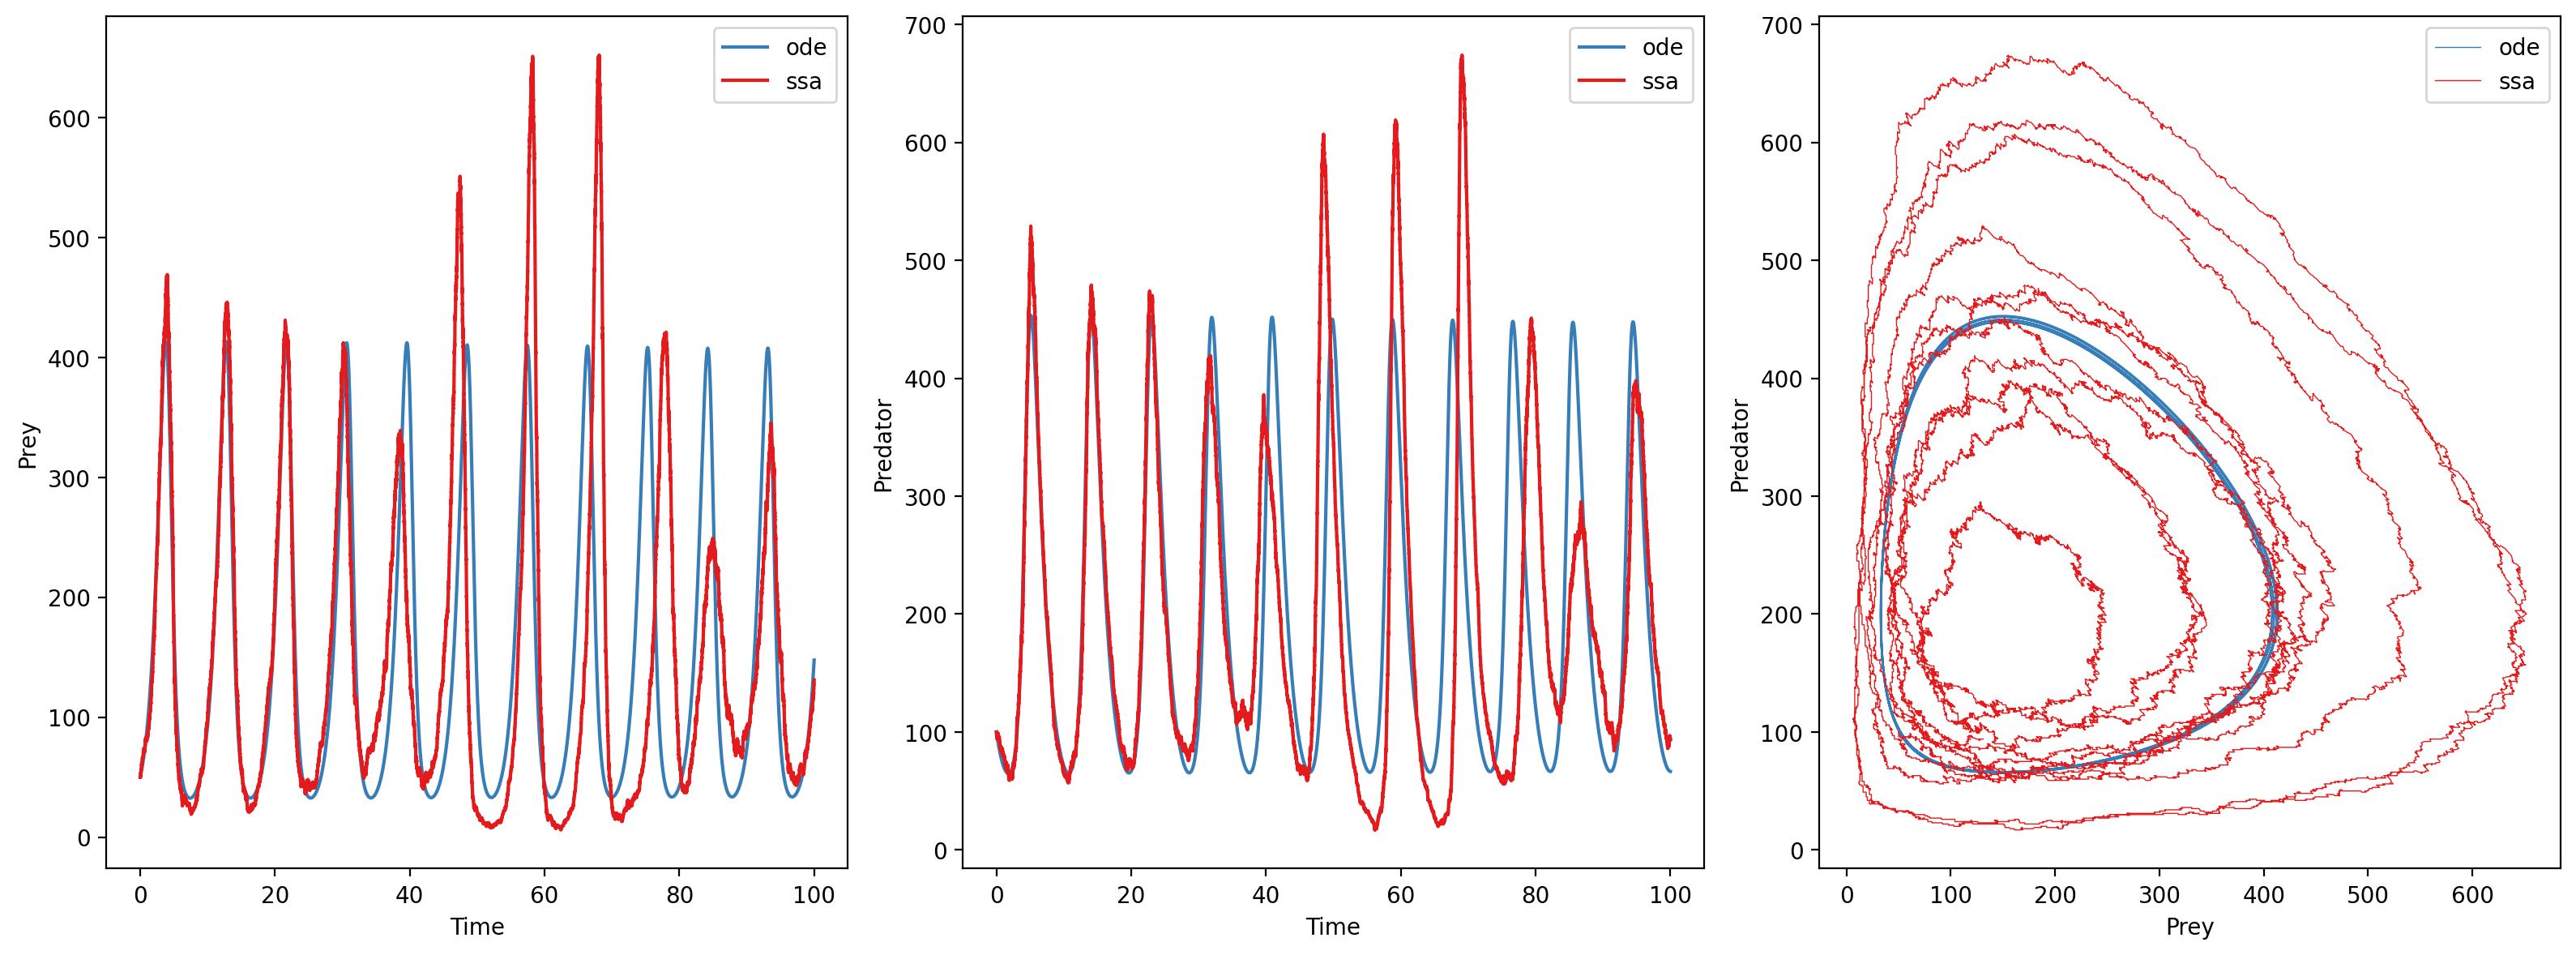

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

ax = axes[0]
ax.plot(T, X, color=blue, label='ode')
ax.plot(t, x, color=red, label='ssa')
ax.set_xlabel('Time')
ax.set_ylabel('Prey')
ax.legend()

ax = axes[1]
ax.plot(T, Y, color=blue, label='ode')
ax.plot(t, y, color=red, label='ssa')
ax.set_xlabel('Time')
ax.set_ylabel('Predator')
ax.legend()

ax = axes[2]
ax.plot(X, Y, lw=0.5, color=blue, label='ode')
ax.plot(x, y, lw=0.5, color=red, label='ssa')
ax.set_xlabel('Prey')
ax.set_ylabel('Predator')
ax.legend()

fig.tight_layout()

## Extinction probability

**Compute the extinction probability of the predators in the first 50 days (assuming `t` is in days) and plot it as a function of $h$ the hunting probability.**

The extinction probability is the probability that the predators populations size reaches zero.
To do that, you will have to run many simulations for the same parameters and check what is the fraction that finished with zero predators.

Think: How many replications should you use per parameter set?
Remember that the standard error of the mean generally decreases like the root of the number of observations ($\sqrt{n}$).

When choosing the number of $h$ values, think if you want to use `np.linspace` or `np.logspace`, or maybe draw random values (from which distribution?) and how many points you should use.

Note that this exercise will require running many simulations; if we estimate the probability from just 100 simulations, and plot against just 10 values of $h$, we still need to run 1000 simulations.

There are several ways to attack this, and they are not mutually exclusive:
1. optimize the simulation code
1. run in parallel on multiple cores on your own machine.
1. use cloud computing on your own (AWS Educate has some free offers for students; Google Colab is free; Digital Ocean is another option).
1. use TAU cluster (`power`).

At any case, make sure to save your simulation results to files so that you can reload them again and change the analysis or plot the figure again (but do not include these files in the assignment submission).

In [26]:
def extinction_probability(b, h, ϵ, d, x0=X[0], y0=Y[0], reps=500):
    txy = np.array([
        gillespie_ssa(b, h, ϵ, d, x0=x0, y0=y0, tmax=50) 
        for _ in range(reps)
    ])
    y = txy[:, 2, :]
    return (y[:,-1]==0).mean()

In [14]:
%%time
hs = np.logspace(-3, 0, 30)
ps = np.array([extinction_probability(b, h_, ϵ, d) for h_ in hs])

CPU times: user 1h 23min 29s, sys: 24.5 s, total: 1h 23min 54s
Wall time: 1h 23min 49s


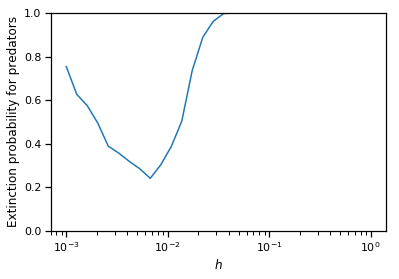

In [15]:
plt.plot(hs, ps)
plt.xlabel('$h$')
plt.ylabel('Extinction probability for predators')
plt.ylim(0, 1)
plt.xscale('log');

__end of assignment__